In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astropy.table import Table
from matplotlib.colors import LogNorm

In [2]:

fontsize = 24 
figsize = (5,8)

plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize})

plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.linewidth'] = 3

In [3]:
query = """
SELECT g.source_id, g.ra, g.dec, parallax, parallax_error,
       pmra, pmra_error, pmdec, pmdec_error,
       phot_g_mean_mag, phot_g_mean_flux_over_error,
       phot_bp_mean_mag, phot_bp_mean_flux_over_error,
       phot_rp_mean_mag, phot_rp_mean_flux_over_error,
       phot_g_mean_mag + 5.0*log10(parallax/100.0) AS M_G, bp_rp,
       s.ra,s.dec, u_mag, u_mag_error, g_mag, g_mag_error, r_mag, r_mag_error, i_mag, i_mag_error, z_mag, z_mag_error, clean_flag,
       pan.ra,pan.dec,g_mean_psf_mag,g_mean_psf_mag_error,r_mean_psf_mag,r_mean_psf_mag_error,i_mean_psf_mag,i_mean_psf_mag_error,z_mean_psf_mag,z_mean_psf_mag_error,y_mean_psf_mag,y_mean_psf_mag_error,s.sdssdr9_oid

FROM   gaiadr3.gaia_source AS g, gaiadr1.sdssdr9_original_valid AS s, gaiadr2.sdssdr9_best_neighbour AS xs,
       gaiadr2.panstarrs1_original_valid AS pan, gaiadr3.panstarrs1_best_neighbour AS xpan
WHERE g.source_id = xs.source_id AND s.sdssdr9_oid = xs.sdssdr9_oid
  AND g.source_id = xpan.source_id AND pan.obj_id = xpan.original_ext_source_id
  AND parallax > 10.0 AND parallax_over_error > 10.0
  AND phot_bp_mean_flux_over_error > 10.0
  AND phot_rp_mean_flux_over_error > 10.0
  AND phot_g_mean_mag + 5.0*log10(parallax/100.0) > (3.333333*(phot_bp_mean_mag - phot_rp_mean_mag) + 8.333333)
  AND (astrometric_sigma5d_max < 1.5 OR (ruwe <= 1.1 AND ipd_gof_harmonic_amplitude < 1))
  AND ((phot_bp_n_obs >2 AND phot_rp_n_obs >2) OR phot_g_mean_mag < 19)
  AND ((astrometric_excess_noise_sig < 2 OR (astrometric_excess_noise_sig >= 2 AND astrometric_excess_noise < 1.5)) OR astrometric_params_solved < 32)
"""

In [4]:
# query_data = Gaia.launch_job_async(query)
# query_result = query_data.get_results()
# gaia_data = query_result.to_pandas()
# print(gaia_data)
# sdssids = gaia_data['sdssdr9_oid']
# objidstr = ",".join(str(obj_id) for obj_id in sdssids)
# print(objidstr)

In [5]:
# gaia_data.to_csv('gaia_query.csv')

In [6]:
gaia_data = pd.read_csv('gaia_query.csv')

In [7]:
montreal_df = pd.read_csv('/home/jovyan/Final_Project/MWDD-export.csv')
montreal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17057 entries, 0 to 17056
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wdid      17057 non-null  object 
 1   icrsra    17057 non-null  object 
 2   icrsdec   17057 non-null  object 
 3   spectype  15807 non-null  object 
 4   teff      15051 non-null  float64
 5   logg      15024 non-null  float64
 6   Dpc       17057 non-null  float64
dtypes: float64(3), object(4)
memory usage: 932.9+ KB


In [8]:
gaia_ra_numpy = gaia_data['ra'].to_numpy()
gaia_dec_numpy = gaia_data['dec'].to_numpy()

In [9]:
montreal_ra_numpy = montreal_df['icrsra'].to_numpy()
montreal_dec_numpy = montreal_df['icrsdec'].to_numpy()

In [10]:
coords = SkyCoord(ra=montreal_ra_numpy,dec=montreal_dec_numpy, unit=(u.hourangle,u.deg))

In [11]:
coords = SkyCoord(ra=montreal_df['icrsra'].to_numpy(),
dec=montreal_df['icrsdec'].to_numpy(), unit=(u.hourangle,u.deg))

In [12]:
gaia_coords=SkyCoord(ra=gaia_data['ra'].to_numpy()*u.deg,dec=gaia_data['dec'].to_numpy()*u.deg)

In [13]:
montreal_df['ra_deg'] = coords.ra.deg
montreal_df['dec_deg']= coords.dec.deg

In [14]:
idx, sep2d,_ = coords.match_to_catalog_sky(gaia_coords)

In [15]:
max_separation = 1.0*u.arcsec
matches_within_radius = sep2d < max_separation

In [16]:
matched_gaia = gaia_data.iloc[idx[matches_within_radius]].reset_index(drop=True)
matched_montreal = montreal_df[matches_within_radius].reset_index(drop=True)

In [51]:
print(matched_gaia)
print("-------------------------------------------------------------------------------")
print(matched_montreal)

      Unnamed: 0            source_id          ra        dec   parallax  \
0           3978   320029150076023808   20.406727  34.678637  25.780560   
1           3365    99498964725981440   32.951316  21.263272  16.818828   
2           4040   139623068897753856   42.435125  33.124953  28.006534   
3           3902  3266873724451739776   47.353642   0.423301  23.498762   
4           4169   250862824946594816   60.258931  51.521455  39.835659   
...          ...                  ...         ...        ...        ...   
4161        4162    98092934167683072   26.671301  21.912874  37.715819   
4162        2004  1289020673097509760  226.275646  32.999870  12.440121   
4163         323  1393328553789078784  227.875811  42.339712  10.281049   
4164         320  1257923215792065152  209.136236  24.268063  10.277937   
4165        2579  1020158400426591872  144.906660  52.028525  13.646575   

      parallax_error        pmra  pmra_error       pmdec  pmdec_error  ...  \
0           0.066413 

In [17]:
finite_test = np.where(np.isfinite(gaia_data))

In [18]:
# HR Diagram for All Stars within 100pc

In [19]:
all_stars = """
SELECT parallax, parallax_error, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp

FROM   gaiadr3.gaia_source_lite AS g

WHERE parallax > 10.0
  AND phot_g_mean_mag < 19
"""

In [20]:
all_stars_data = Gaia.launch_job_async(all_stars)
all_stars_result = all_stars_data.get_results()
general_data = all_stars_result.to_pandas()
print(general_data)

INFO: Query finished. [astroquery.utils.tap.core]
          parallax  parallax_error  phot_g_mean_mag  phot_bp_mean_mag  \
0        10.000008        0.033425        15.390248         16.919266   
1        10.000029        0.012865        13.608475         14.623214   
2        10.000032        0.013737         9.267752          9.624231   
3        10.000042        0.077917        16.122866         17.475218   
4        10.000051        0.198665        18.146105         20.622805   
...            ...             ...              ...               ...   
294125  374.489589        0.231335         8.524133          8.120362   
294126  392.752945        0.032067         6.551172          7.691122   
294127  415.179416        0.068371        11.038391         13.770287   
294128  546.975940        0.040116         8.193974          9.791788   
294129  768.066539        0.049873         8.984749         11.373116   

        phot_rp_mean_mag     bp_rp  
0              14.187394  2.731872  

In [46]:
# general_data.to_csv('all_stars_query.csv')

In [21]:
finite_test_general = np.where(np.isfinite(general_data))

In [22]:
print(len(finite_test_general[0]))
print(len(general_data))
comparison_general = 294130 * 6
print(comparison_general)

1744094
294130
1764780


In [23]:
# Since comparison is not equal to the number of finite vales, there are non-finite data values

In [24]:
good_general_data = general_data[np.isfinite(general_data).all(axis=1)]
print(good_general_data)

          parallax  parallax_error  phot_g_mean_mag  phot_bp_mean_mag  \
0        10.000008        0.033425        15.390248         16.919266   
1        10.000029        0.012865        13.608475         14.623214   
2        10.000032        0.013737         9.267752          9.624231   
3        10.000042        0.077917        16.122866         17.475218   
4        10.000051        0.198665        18.146105         20.622805   
...            ...             ...              ...               ...   
294125  374.489589        0.231335         8.524133          8.120362   
294126  392.752945        0.032067         6.551172          7.691122   
294127  415.179416        0.068371        11.038391         13.770287   
294128  546.975940        0.040116         8.193974          9.791788   
294129  768.066539        0.049873         8.984749         11.373116   

        phot_rp_mean_mag     bp_rp  
0              14.187394  2.731872  
1              12.597395  2.025819  
2           

In [25]:
# Testing the cleaned data
finite_test_general2 = np.where(np.isfinite(good_general_data))
comparison_general2 = 287215 * 6
print(len(finite_test_general2[0]))
print(comparison_general2)

1723290
1723290


In [26]:
# Now they match so all of the data is now valid finite values

In [27]:
G_magnitude_general = good_general_data.phot_g_mean_mag
parallax_general = good_general_data.parallax

print(parallax_general)
print(G_magnitude_general)

0          10.000008
1          10.000029
2          10.000032
3          10.000042
4          10.000051
             ...    
294125    374.489589
294126    392.752945
294127    415.179416
294128    546.975940
294129    768.066539
Name: parallax, Length: 287215, dtype: float64
0         15.390248
1         13.608475
2          9.267752
3         16.122866
4         18.146105
            ...    
294125     8.524133
294126     6.551172
294127    11.038391
294128     8.193974
294129     8.984749
Name: phot_g_mean_mag, Length: 287215, dtype: float32


In [28]:
G_abs_magnitude_general = G_magnitude_general + 5.0*np.log10(parallax_general/100.0)
print(G_abs_magnitude_general)

0         10.390250
1          8.608481
2          4.267759
3         11.122875
4         13.146116
            ...    
294125    11.391331
294126     9.521769
294127    14.129570
294128    11.883816
294129    13.411743
Length: 287215, dtype: float64


In [29]:
dist_mod_general = G_magnitude_general - G_abs_magnitude_general
print(dist_mod_general)
print(np.max(dist_mod_general))

0         4.999998
1         4.999994
2         4.999993
3         4.999991
4         4.999989
            ...   
294125   -2.867199
294126   -2.970597
294127   -3.091179
294128   -3.689841
294129   -4.426994
Length: 287215, dtype: float64
4.999998191624629


In [30]:
bp_rp_general = good_general_data.bp_rp
print(bp_rp_general)

0         2.731872
1         2.025819
2         0.880858
3         2.855918
4         3.844704
            ...   
294125   -0.278427
294126    2.215609
294127    4.184836
294128    2.833697
294129    3.804580
Name: bp_rp, Length: 287215, dtype: float32


Text(0.5, 1.0, 'All Stars Within 100 pc')

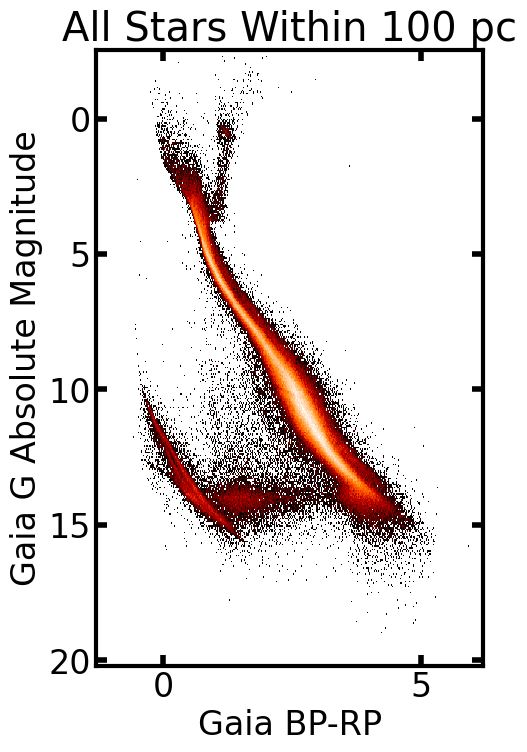

In [31]:
plt.hist2d(bp_rp_general,G_abs_magnitude_general,bins=400,norm=LogNorm(),cmap='gist_heat')
plt.xlabel('Gaia BP-RP')
plt.ylabel('Gaia G Absolute Magnitude')
plt.gca().invert_yaxis()
plt.title("All Stars Within 100 pc")

In [32]:
# HR Diagram for All White Dwarfs within 100pc

In [33]:
print(len(finite_test[0]))
print(len(gaia_data))
comparison = 4214 * 44
print(comparison)

184088
4214
185416


In [34]:
# Since comparison is not equal to the number of finite vales, there are non-finite data values

In [35]:
good_data = gaia_data[np.isfinite(gaia_data).all(axis=1)]
print(good_data)

      Unnamed: 0            source_id          ra        dec    parallax  \
0              0   934814647180364032  121.394370  49.446565   10.002614   
1              1  3727082704328532480  207.069881  10.639423   10.003681   
2              2  1543840528716704512  188.371366  48.146928   10.004696   
3              3   859817100784374144  179.762388  62.032129   10.005049   
4              4  2492027264515309696   28.566384  -4.446301   10.005247   
...          ...                  ...         ...        ...         ...   
4207        4207  3714914271705535360  205.338909   5.012820   68.155477   
4208        4208  2480523216087975040   24.500065  -4.997298   79.243196   
4209        4209  4235280071072332672  299.119830  -1.045547   86.465801   
4211        4211  1792830060723673472  325.669790  20.996592   90.545376   
4212        4212  2349916559152267008   10.356220 -22.352334  109.927642   

      parallax_error        pmra  pmra_error       pmdec  pmdec_error  ...  \
0        

In [36]:
# Testing the cleaned data
finite_test2 = np.where(np.isfinite(good_data))
comparison2 = 3957 * 44
print(len(finite_test2[0]))
print(comparison2)

174108
174108


In [37]:
# Now they match so all of the data is now valid finite values

In [38]:
G_magnitude = good_data.phot_g_mean_mag
parallax = good_data.parallax

print(parallax)
print(G_magnitude)

0        10.002614
1        10.003681
2        10.004696
3        10.005049
4        10.005247
           ...    
4207     68.155477
4208     79.243196
4209     86.465801
4211     90.545376
4212    109.927642
Name: parallax, Length: 3957, dtype: float64
0       19.735939
1       20.090410
2       19.866638
3       19.335940
4       18.926456
          ...    
4207    16.314335
4208    12.744349
4209    13.591183
4211    13.174672
4212    14.297183
Name: phot_g_mean_mag, Length: 3957, dtype: float64


In [39]:
G_abs_magnitude = G_magnitude + 5.0*np.log10(parallax/100.0)
print(G_abs_magnitude)

0       14.736507
1       15.091209
2       14.867657
3       14.337036
4       13.927595
          ...    
4207    15.481839
4208    12.239159
4209    13.275405
4211    12.959003
4212    14.502718
Length: 3957, dtype: float64


In [40]:
dist_mod = G_magnitude - G_abs_magnitude
print(dist_mod)
print(np.max(dist_mod))

0       4.999432
1       4.999201
2       4.998981
3       4.998904
4       4.998861
          ...   
4207    0.832496
4208    0.505190
4209    0.315778
4211    0.215669
4212   -0.205535
Length: 3957, dtype: float64
4.999432396055862


In [41]:
bp_rp = good_data.bp_rp
print(bp_rp)

0       0.602072
1       1.375725
2       1.000086
3       0.599569
4       0.753017
          ...   
4207    1.490633
4208    0.492883
4209    0.395058
4211    0.233660
4212    0.911183
Name: bp_rp, Length: 3957, dtype: float64


Text(0.5, 1.0, 'All White Dwarfs Within 100 pc')

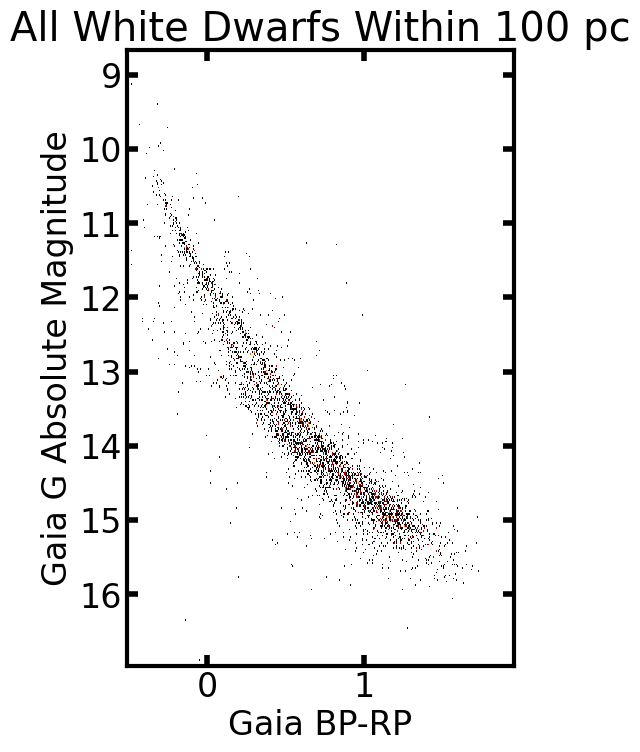

In [42]:
plt.hist2d(bp_rp,G_abs_magnitude,bins=400,norm=LogNorm(),cmap='gist_heat')
plt.xlabel('Gaia BP-RP')
plt.ylabel('Gaia G Absolute Magnitude')
plt.gca().invert_yaxis()
plt.title("All White Dwarfs Within 100 pc")

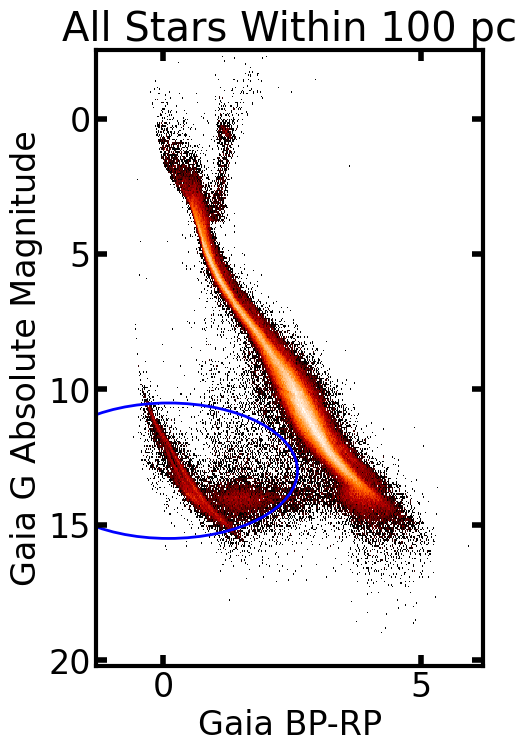

In [43]:
plt.hist2d(bp_rp_general,G_abs_magnitude_general,bins=400,norm=LogNorm(),cmap='gist_heat')
plt.xlabel('Gaia BP-RP')
plt.ylabel('Gaia G Absolute Magnitude')
ax=plt.gca()
plt.gca().invert_yaxis()
plt.title("All Stars Within 100 pc")
circle = plt.Circle((0.1, 13),
                     2.5, color='blue', lw=2, fill=False)
ax.add_patch(circle)

In [48]:
names = good_data.source_id
print(names)

0        934814647180364032
1       3727082704328532480
2       1543840528716704512
3        859817100784374144
4       2492027264515309696
               ...         
4207    3714914271705535360
4208    2480523216087975040
4209    4235280071072332672
4211    1792830060723673472
4212    2349916559152267008
Name: source_id, Length: 3957, dtype: int64


In [ ]:
Gaia Bandpasses (Angstrums)
G: 6600
GBP: 5050
GRP: 8450

In [ ]:
PanSTARRS Bandpasses (Angstrums)
g: 4886
r: 6215
i: 7545
z: 8679
y: 9633

In [ ]:
SDSS Bandpasses (Angstrums)
u: 3551
g: 4686
r: 6166
i: 7480
z: 8932